
# Modelo por Segmento (Plato) — XGBoost
**Fecha:** 2025-11-01 23:17:09

Este notebook entrena **un modelo por plato** para mejorar la precisión (accuracy) aprovechando patrones específicos de cada segmento.

**Estructura:**
1. Imports y Configuración  
2. Carga robusta del dataset + Detección flexible de columnas  
3. Preparación de features y generación opcional de lags/rollings  
4. **Tuning por Segmento** con `RandomizedSearchCV` (compatibilidad sin early-stopping en CV)  
5. **Reentrenamiento Final por Segmento** con early-stopping vía `xgboost.train`  
6. Métricas por segmento + Métrica global (promedio ponderado)  
7. Próximos pasos sugeridos según resultados


In [1]:

# 1) Imports y Configuración
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint

import xgboost as xgb
from xgboost import XGBRegressor

print("xgboost version:", xgb.__version__)

xgboost version: 3.1.2


In [6]:

# 2) Carga robusta del dataset + Detección flexible de columnas

# Ajusta esta ruta si tu CSV está en otra ubicación.
CANDIDATE_PATHS = [
    Path("../../data/processed/dataset_forecast_diario.csv"),
    Path("/content/-1INF46-Plan_Compras_Produccion/data/processed/dataset_forecast_diario.csv"),
    Path("/workspace/-1INF46-Plan_Compras_Produccion/data/processed/dataset_forecast_diario.csv"),
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break

print("DATA_PATH encontrado:", DATA_PATH)

assert DATA_PATH is not None, "No se encontró el dataset. Ajusta CANDIDATE_PATHS o define DATA_PATH manualmente."
df = pd.read_csv(DATA_PATH)

DATE_COL_CANDS = ["fecha", "ds", "date", "FECHA"]
TARGET_CANDS    = ["cantidad", "ventas", "ventas_total", "venta_total", "y", "target", "ventas_real"]
PLATO_CANDS     = ["plato", "plato_id", "id_plato", "producto", "categoria"]

CALENDAR_CANDS = {
    "feriado":        ["feriado","is_holiday","es_feriado"],
    "fin_de_semana":  ["fin_de_semana","is_weekend"],
    "dow":            ["dia_semana","dow"],
    "mes":            ["mes","month"],
}

SERIES_CANDS = [
    "lag_1","lag_7","lag_14","lag_21","lag_28",
    "rolling_mean_7","rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28"
]

def pick_col(cands, cols_lower):
    for c in cands:
        if c in cols_lower:
            return c
    return None

# normaliza nombres para búsqueda (lower)
cols_lower = [c.lower() for c in df.columns]
colmap = {c.lower(): c for c in df.columns}

date_col   = pick_col(DATE_COL_CANDS, cols_lower)
target_col = pick_col(TARGET_CANDS, cols_lower)
plato_col  = pick_col(PLATO_CANDS, cols_lower)

assert date_col is not None, f"No se detectó columna de fecha. Candidatas: {DATE_COL_CANDS}"
assert target_col is not None, f"No se detectó target (ventas). Candidatas: {TARGET_CANDS}"
assert plato_col is not None, f"No se detectó columna de 'plato' o categoría. Candidatas: {PLATO_CANDS}"

# mapea a nombres originales (case original)
DATE_COL   = colmap[date_col]
TARGET_COL = colmap[target_col]
PLATO_COL  = colmap[plato_col]

calendar_cols = {}
for k, cands in CALENDAR_CANDS.items():
    sel = pick_col(cands, cols_lower)
    if sel is not None:
        calendar_cols[k] = colmap[sel]

series_cols = [colmap[c] for c in SERIES_CANDS if c in cols_lower]

print("Detectado:")
print(" - Fecha      :", DATE_COL)
print(" - Target     :", TARGET_COL)
print(" - Segmento   :", PLATO_COL)
print(" - Calendario :", calendar_cols)
print(" - Series     :", series_cols)

# parse de fecha y orden
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.sort_values(DATE_COL).reset_index(drop=True)

# Por si hay valores nulos en target, eliminarlos
df = df.dropna(subset=[TARGET_COL])
print("Shape:", df.shape)
df.head(3)


DATA_PATH encontrado: ..\..\data\processed\dataset_forecast_diario.csv
Detectado:
 - Fecha      : fecha
 - Target     : cantidad
 - Segmento   : plato
 - Calendario : {'feriado': 'feriado', 'fin_de_semana': 'fin_de_semana', 'dow': 'dow', 'mes': 'mes'}
 - Series     : ['lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28']
Shape: (21530, 46)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2021-01-15,1,13.0,338.0,2021,1,15,4,0,0,...,19.000000,4.123106,19.642857,5.415180,NaN,NaN,-0.433884,-0.900969,0.0,1.0
1,2021-01-15,5,21.0,525.0,2021,1,15,4,0,0,...,12.571429,2.819997,11.928571,2.894671,NaN,NaN,-0.433884,-0.900969,0.0,1.0
2,2021-01-15,6,11.0,264.0,2021,1,15,4,0,0,...,9.571429,2.070197,10.428571,2.737609,NaN,NaN,-0.433884,-0.900969,0.0,1.0


In [7]:
df.filter(regex="temp").head()

,temp_invierno,temp_otono,temp_primavera,temp_verano
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True


In [8]:

# 3) Preparación de features (lags/rollings si faltan)
NEED_LAGS = any(c not in df.columns for c in ["lag_7", "rolling_mean_7", "rolling_std_7"])

def add_lags_rollings(g, target, lags=[1,7,14,21,28], wins=[7,14,28]):
    g = g.sort_values(DATE_COL).copy()
    for L in lags:
        g[f"lag_{L}"] = g[target].shift(L)
    for W in wins:
        g[f"rolling_mean_{W}"] = g[target].shift(1).rolling(W, min_periods=max(2, W//2)).mean()
        g[f"rolling_std_{W}"]  = g[target].shift(1).rolling(W, min_periods=max(2, W//2)).std()
    return g

if NEED_LAGS:
    print("Generando lags/rollings por segmento…")
    df = df.groupby(PLATO_COL, group_keys=False).apply(lambda g: add_lags_rollings(g, TARGET_COL))

# Definición de features
regressors = []
regressors += list(calendar_cols.values())
regressors += [c for c in series_cols if c in df.columns]

# Limpieza mínima
for c in regressors:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df_model = df.dropna(subset=regressors + [TARGET_COL]).copy()
print("Dataset modelable:", df_model.shape)

seg_counts = df_model.groupby(PLATO_COL)[TARGET_COL].size().sort_values(ascending=False)
print("Top segmentos por cantidad de filas:")
print(seg_counts.head(10))


Dataset modelable: (21362, 46)
Top segmentos por cantidad de filas:
plato
1     1798
2     1798
3     1798
4     1798
5     1798
6     1798
7     1798
8     1798
9     1796
10    1763
Name: cantidad, dtype: int64


In [9]:
# 4) Utilidades de métrica
def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    # Calculate RMSE manually as squared=False might not be supported in older sklearn versions
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
    smape= 100*np.mean(2*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)+1e-6))
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"MAPE":mape,"sMAPE":smape,"Accuracy(1-MAPE)":100-mape}


## 4) Tuning por Segmento con `RandomizedSearchCV` (Random Forest)

Se realizará una búsqueda aleatoria de hiperparámetros para `RandomForestRegressor` para cada segmento (`PLATO_COL`) utilizando `TimeSeriesSplit` para la validación cruzada. Esto asegura que el modelo se entrena y valida en ventanas de tiempo consistentes.

In [10]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

print("xgboost version:", xgb.__version__)

xgboost version: 3.1.2


In [11]:
# Parámetros para RandomizedSearchCV de Random Forest
param_dist = {
    'n_estimators': randint(50, 200),  # Número de árboles en el bosque
    'max_depth': randint(5, 20),       # Profundidad máxima de cada árbol
    'min_samples_split': randint(2, 20), # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': randint(1, 10),  # Número mínimo de muestras requeridas para ser un nodo hoja
    'max_features': uniform(0.5, 0.5), # El número de características a considerar al buscar la mejor división
}

# Configuración de TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

best_params_per_segment = {}
segment_models = {}

print(f"Iniciando tuning para {len(df_model[PLATO_COL].unique())} segmentos...")

for i, (segment_name, segment_df) in enumerate(df_model.groupby(PLATO_COL)):
    if i % 5 == 0: # Print progress every 5 segments
        print(f"Procesando segmento {i+1}/{len(df_model[PLATO_COL].unique())}: {segment_name}")

    # Asegurarse de que el dataframe esté ordenado por fecha para TimeSeriesSplit
    segment_df = segment_df.sort_values(DATE_COL).copy()

    X = segment_df[regressors]
    y = segment_df[TARGET_COL]

    # Eliminar NaNs que puedan haber quedado de los lags/rollings al inicio de la serie de tiempo
    # RandomizedSearchCV no maneja NaNs
    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # Asegurarse de tener suficientes datos para el TimeSeriesSplit
    if len(X) < tscv.n_splits + 1: # Mínimo n_splits + 1 para TimeSeriesSplit
        print(f"  Saltando segmento {segment_name}: pocos datos ({len(X)} filas).")
        continue

    # Inicializar el modelo Random Forest
    rf = RandomForestRegressor(random_state=42, n_jobs=-1) # n_jobs=-1 para usar todos los cores

    # Configurar RandomizedSearchCV
    # No se usa early-stopping aquí, ya que RandomizedSearchCV no tiene un mecanismo directo para ello con TimeSeriesSplit
    # El early stopping se aplicará en el reentrenamiento final con un bucle manual
    random_search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=50,  # Número de combinaciones de parámetros a probar
        scoring='neg_mean_absolute_error', # Buscar minimizar MAE
        cv=tscv,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    try:
        random_search.fit(X, y)
        best_params_per_segment[segment_name] = random_search.best_params_
        print(f"  Segmento {segment_name}: Mejores parámetros encontrados: {random_search.best_params_}")
    except Exception as e:
        print(f"  Error al tunear el segmento {segment_name}: {e}")
        continue

print("Tuning completado.")

# Opcional: Mostrar algunos de los mejores parámetros encontrados
print("\nAlgunos de los mejores parámetros por segmento:")
for i, (seg, params) in enumerate(best_params_per_segment.items()):
    if i < 5: # Muestra los primeros 5
        print(f"  {seg}: {params}")
    else:
        break


Iniciando tuning para 12 segmentos...
Procesando segmento 1/12: 1
  Segmento 1: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.7469468575917173), 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 184}
  Segmento 2: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.7469468575917173), 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 184}
  Segmento 3: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.5078182033705969), 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 185}
  Segmento 4: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.5465513839029497), 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 58}
  Segmento 5: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.5465513839029497), 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 58}
Procesando segmento 6/12: 6
  Segmento 6:

## 5) Reentrenamiento Final por Segmento con `RandomForestRegressor`

Una vez que se han determinado los mejores hiperparámetros para cada segmento, se entrenará un modelo `RandomForestRegressor` final para cada uno. Aquí se puede considerar una estrategia de validación en hold-out para evaluar el rendimiento final o simplemente entrenar con todos los datos disponibles con los mejores parámetros.

In [12]:
final_models_rf = {}
segment_predictions_rf = pd.DataFrame()

print(f"Iniciando reentrenamiento final para {len(best_params_per_segment)} segmentos...")

for i, (segment_name, params) in enumerate(best_params_per_segment.items()):
    if i % 5 == 0: # Print progress every 5 segments
        print(f"Reentrenando segmento {i+1}/{len(best_params_per_segment)}: {segment_name}")

    segment_df = df_model[df_model[PLATO_COL] == segment_name].sort_values(DATE_COL).copy()

    X = segment_df[regressors]
    y = segment_df[TARGET_COL]

    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    if len(X) == 0:
        print(f"  Saltando segmento {segment_name}: no hay datos válidos después de eliminar NaNs.")
        continue

    # Inicializar y entrenar el modelo Random Forest con los mejores parámetros
    final_rf_model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    final_rf_model.fit(X, y)

    # Guardar el modelo entrenado
    final_models_rf[segment_name] = final_rf_model

    # Generar predicciones para el conjunto de entrenamiento (opcional, para métricas)
    segment_df.loc[valid_idx, 'rf_pred'] = final_rf_model.predict(X)
    segment_predictions_rf = pd.concat([segment_predictions_rf, segment_df.loc[valid_idx]], ignore_index=True)

print("Reentrenamiento final completado.")

# Opcional: Mostrar las primeras filas de las predicciones
print("\nPrimeras filas de las predicciones de Random Forest:")
print(segment_predictions_rf[['fecha', PLATO_COL, TARGET_COL, 'rf_pred']].head())


Iniciando reentrenamiento final para 12 segmentos...
Reentrenando segmento 1/12: 1
Reentrenando segmento 6/12: 6
Reentrenando segmento 11/12: 11
Reentrenamiento final completado.

Primeras filas de las predicciones de Random Forest:
       fecha  plato  cantidad    rf_pred
0 2021-01-29      1      17.0  19.545654
1 2021-01-30      1      24.0  23.272610
2 2021-01-31      1      27.0  23.272096
3 2021-02-01      1      14.0  18.731927
4 2021-02-02      1      19.0  19.066123


## 6) Métricas por segmento + Métrica global (promedio ponderado) para Random Forest

Se calcularán las métricas de evaluación para cada segmento de forma individual y se consolidará una métrica global ponderada.

In [13]:
metrics_rf_df = []

print("Calculando métricas para Random Forest...")

for segment_name, seg_df in segment_predictions_rf.groupby(PLATO_COL):
    y_true = seg_df[TARGET_COL]
    y_pred = seg_df['rf_pred']

    metrics = eval_metrics(y_true, y_pred)
    metrics['segmento'] = segment_name
    metrics['num_samples'] = len(seg_df)
    metrics_rf_df.append(metrics)

metrics_rf_df = pd.DataFrame(metrics_rf_df)
metrics_rf_df = metrics_rf_df.sort_values(by='MAE', ascending=True)

print("\nMétricas por segmento (Random Forest):")
print(metrics_rf_df.head(12))

# Métrica global ponderada por el número de muestras
total_samples = metrics_rf_df['num_samples'].sum()
weighted_mae  = (metrics_rf_df['MAE'] * metrics_rf_df['num_samples']).sum() / total_samples
weighted_rmse = (metrics_rf_df['RMSE'] * metrics_rf_df['num_samples']).sum() / total_samples
weighted_mape = (metrics_rf_df['MAPE'] * metrics_rf_df['num_samples']).sum() / total_samples
weighted_smape= (metrics_rf_df['sMAPE'] * metrics_rf_df['num_samples']).sum() / total_samples

print("\nMétrica Global Ponderada (Random Forest):")
print(f"  MAE : {weighted_mae:.2f}")
print(f"  RMSE: {weighted_rmse:.2f}")
print(f"  MAPE: {weighted_mape:.2f}%")
print(f"  sMAPE: {weighted_smape:.2f}%")
print(f"  Accuracy(1-MAPE): {100 - weighted_mape:.2f}%")


Calculando métricas para Random Forest...

Métricas por segmento (Random Forest):
         MAE      RMSE        R2       MAPE      sMAPE  Accuracy(1-MAPE)  \
11  1.178422  1.460377  0.200174  57.753474  42.101172         42.246526   
10  1.439037  1.789459  0.163736  53.026206  37.510479         46.973794   
9   1.482236  1.865860  0.147014  55.915833  38.539134         44.084167   
8   1.982069  2.478827  0.179794  39.835121  30.119404         60.164879   
6   2.046665  2.554254  0.396773  25.795153  21.891720         74.204847   
7   2.172766  2.746597  0.193265  33.843248  27.499097         66.156752   
5   2.685719  3.335680  0.252922  25.261856  22.279353         74.738144   
4   2.847102  3.559274  0.234163  24.121171  21.545399         75.878829   
2   2.932755  3.683399  0.355477  23.463331  20.702906         76.536669   
3   3.225579  4.063252  0.221190  20.427753  18.647177         79.572247   
0   3.407325  4.314843  0.287009  16.840412  15.863900         83.159588   
1   3.

## 7) Próximos pasos sugeridos según resultados

Una vez obtenidas las métricas para Random Forest, se pueden comparar con los resultados previos de XGBoost (si se tienen a mano) para determinar qué modelo ofrece un mejor rendimiento general o para segmentos específicos.

**Posibles próximos pasos:**

1.  **Comparar modelos:** Realizar una comparación detallada de las métricas de Random Forest con las obtenidas previamente con XGBoost. Identificar qué modelo es superior en general y en qué segmentos.
2.  **Análisis de errores:** Investigar los segmentos con mayor error para entender las causas. ¿Faltan características? ¿Hay anomalías en los datos?
3.  **Ingeniería de características:** Crear nuevas características que puedan ser útiles para el modelo (e.g., indicadores de eventos especiales, tendencias, estacionalidad).
4.  **Optimización de hiperparámetros:** Si se necesita mayor precisión, se podría realizar un `GridSearchCV` más exhaustivo o probar otras estrategias de optimización.
5.  **Validación Robusta:** Implementar una estrategia de validación más avanzada, como *rolling forecast origin* o *walk-forward validation*, para una evaluación más realista del rendimiento del modelo en producción.
6.  **Otros modelos:** Experimentar con otros modelos de series de tiempo o ensambles de modelos si los resultados aún no son satisfactorios.

# Task
Revisar los segmentos de baja precisión en el DataFrame `metrics_rf_df` (donde 'Accuracy(1-MAPE)' es inferior al 60%) y decidir la estrategia a seguir para mejorar su rendimiento, considerando el reajuste del Random Forest o la exploración de modelos de ensamble.

## Identificar Segmentos con Baja Precisión

### Subtask:
Filtrar el DataFrame `metrics_rf_df` para encontrar todos los segmentos donde la métrica 'Accuracy(1-MAPE)' es inferior al 60%.


**Reasoning**:
To identify segments with low accuracy, I need to filter the `metrics_rf_df` DataFrame based on the 'Accuracy(1-MAPE)' column being less than 60%.



In [14]:
low_accuracy_segments_rf = metrics_rf_df[metrics_rf_df['Accuracy(1-MAPE)'] < 60]
print("Segmentos con 'Accuracy(1-MAPE)' inferior al 60% (Random Forest):")
print(low_accuracy_segments_rf)

Segmentos con 'Accuracy(1-MAPE)' inferior al 60% (Random Forest):
         MAE      RMSE        R2       MAPE      sMAPE  Accuracy(1-MAPE)  \
11  1.178422  1.460377  0.200174  57.753474  42.101172         42.246526   
10  1.439037  1.789459  0.163736  53.026206  37.510479         46.973794   
9   1.482236  1.865860  0.147014  55.915833  38.539134         44.084167   

    segmento  num_samples  
11        12         1659  
10        11         1760  
9         10         1763  


## Proponer Estrategia de Mejora para Segmentos Específicos

### Subtask:
Proponer opciones para mejorar la precisión de los segmentos identificados con baja precisión. Esto puede incluir re-ajustar el Random Forest con una búsqueda de hiperparámetros más exhaustiva o explorar la combinación con otro tipo de modelo para crear un ensamble.


## Proponer Estrategia de Mejora para Segmentos Específicos

Para los segmentos identificados con baja precisión (segmentos 10, 11 y 12), donde el 'Accuracy(1-MAPE)' es inferior al 60% y el R2 es particularmente bajo (alrededor de 0.15-0.20), se sugieren las siguientes estrategias:

### Análisis de los Segmentos de Baja Precisión (10, 11, 12):
*   **R2 bajo**: El coeficiente de determinación (R2) muy bajo indica que el modelo Random Forest explica muy poca variabilidad en las ventas para estos segmentos. Esto sugiere que el modelo actual no está capturando bien los patrones esenciales o que los patrones son más complejos de lo que el Random Forest actual puede manejar con los hiperparámetros encontrados.
*   **MAPE/sMAPE altos**: Los valores altos de MAPE y sMAPE confirman que las predicciones tienen un error porcentual considerable, afectando directamente la precisión.
*   **Número de muestras**: El número de muestras para estos segmentos (alrededor de 1600-1700) no es excesivamente bajo en comparación con otros, por lo que una escasez de datos no parece ser la causa principal de la baja precisión.

### Estrategia Propuesta: Exploración de Ensamble con XGBoost

Dado el bajo rendimiento general del Random Forest para estos segmentos, la estrategia más prometedora es **explorar un ensamble o la sustitución del modelo con XGBoost** para los segmentos 10, 11 y 12.

**Justificación:**
*   **Capacidad de Modelado de Patrones Complejos**: XGBoost, siendo un algoritmo de gradient boosting, es conocido por su capacidad para manejar relaciones no lineales y capturar patrones complejos en los datos, lo cual el Random Forest actual no está logrando para estos segmentos. Puede ser más efectivo para series de tiempo con estacionalidad, tendencias o eventos que no están siendo adecuadamente modelados.
*   **Reaprovechamiento de Tuning Existente (si aplica)**: Si ya se ha realizado un tuning de XGBoost en una fase anterior (como lo sugería la estructura inicial del notebook), se podrían aplicar esos parámetros directamente a estos segmentos o realizar un tuning específico de XGBoost para ellos. Esto permitiría comparar directamente el rendimiento y ver si XGBoost ofrece una mejora sustancial.
*   **Ensamble (Meta-Learning)**: Otra opción es entrenar un modelo XGBoost para estos segmentos y luego combinar sus predicciones con las del Random Forest mediante un enfoque de ensamble (por ejemplo, *stacking* o *blending*). Esto podría capitalizar las fortalezas de ambos modelos, si cada uno captura diferentes aspectos de los datos.

### Acción Recomendada:
1.  **Entrenar y Tunear XGBoost para Segmentos 10, 11, 12**: Realizar un `RandomizedSearchCV` o `GridSearchCV` específico para `XGBRegressor` en estos tres segmentos, utilizando los mismos `regressors` y la misma estrategia de `TimeSeriesSplit`.
2.  **Comparar Métricas**: Comparar las métricas de XGBoost con las obtenidas por Random Forest para determinar cuál modelo es superior para cada uno de estos segmentos problemáticos.
3.  **Implementar el Mejor Modelo**: Utilizar el modelo que ofrezca las mejores métricas (XGBoost o Random Forest re-tuneado) para cada segmento individual. Si XGBoost funciona significativamente mejor, considerar su integración completa o un ensamble.

Esta estrategia apunta a utilizar un modelo con mayor capacidad para aprender de los datos, lo que es crucial cuando los modelos más simples (o con un tuning menos exhaustivo) no logran la precisión deseada.

## Proponer Estrategia de Mejora para Segmentos Específicos

Para los segmentos identificados con baja precisión (segmentos 10, 11 y 12), donde el 'Accuracy(1-MAPE)' es inferior al 60% y el R2 es particularmente bajo (alrededor de 0.15-0.20), se sugieren las siguientes estrategias:

### Análisis de los Segmentos de Baja Precisión (10, 11, 12):
*   **R2 bajo**: El coeficiente de determinación (R2) muy bajo indica que el modelo Random Forest explica muy poca variabilidad en las ventas para estos segmentos. Esto sugiere que el modelo actual no está capturando bien los patrones esenciales o que los patrones son más complejos de lo que el Random Forest actual puede manejar con los hiperparámetros encontrados.
*   **MAPE/sMAPE altos**: Los valores altos de MAPE y sMAPE confirman que las predicciones tienen un error porcentual considerable, afectando directamente la precisión.
*   **Número de muestras**: El número de muestras para estos segmentos (alrededor de 1600-1700) no es excesivamente bajo en comparación con otros, por lo que una escasez de datos no parece ser la causa principal de la baja precisión.

### Estrategia Propuesta: Exploración de Ensamble con XGBoost

Dado el bajo rendimiento general del Random Forest para estos segmentos, la estrategia más prometedora es **explorar un ensamble o la sustitución del modelo con XGBoost** para los segmentos 10, 11 y 12.

**Justificación:**
*   **Capacidad de Modelado de Patrones Complejos**: XGBoost, siendo un algoritmo de gradient boosting, es conocido por su capacidad para manejar relaciones no lineales y capturar patrones complejos en los datos, lo cual el Random Forest actual no está logrando para estos segmentos. Puede ser más efectivo para series de tiempo con estacionalidad, tendencias o eventos que no están siendo adecuadamente modelados.
*   **Reaprovechamiento de Tuning Existente (si aplica)**: Si ya se ha realizado un tuning de XGBoost en una fase anterior (como lo sugería la estructura inicial del notebook), se podrían aplicar esos parámetros directamente a estos segmentos o realizar un tuning específico de XGBoost para ellos. Esto permitiría comparar directamente el rendimiento y ver si XGBoost ofrece una mejora sustancial.
*   **Ensamble (Meta-Learning)**: Otra opción es entrenar un modelo XGBoost para estos segmentos y luego combinar sus predicciones con las del Random Forest mediante un enfoque de ensamble (por ejemplo, *stacking* o *blending*). Esto podría capitalizar las fortalezas de ambos modelos, si cada uno captura diferentes aspectos de los datos.

### Acción Recomendada:
1.  **Entrenar y Tunear XGBoost para Segmentos 10, 11, 12**: Realizar un `RandomizedSearchCV` o `GridSearchCV` específico para `XGBRegressor` en estos tres segmentos, utilizando los mismos `regressors` y la misma estrategia de `TimeSeriesSplit`.
2.  **Comparar Métricas**: Comparar las métricas de XGBoost con las obtenidas por Random Forest para determinar cuál modelo es superior para cada uno de estos segmentos problemáticos.
3.  **Implementar el Mejor Modelo**: Utilizar el modelo que ofrezca las mejores métricas (XGBoost o Random Forest re-tuneado) para cada segmento individual. Si XGBoost funciona significativamente mejor, considerar su integración completa o un ensamble.

Esta estrategia apunta a utilizar un modelo con mayor capacidad para aprender de los datos, lo que es crucial cuando los modelos más simples (o con un tuning menos exhaustivo) no logran la precisión deseada.

## Final Task

### Subtask:
Revisar los segmentos de baja precisión y decidir la estrategia a seguir para mejorar su rendimiento.


## Summary:

### Q&A
1.  **¿Cuáles son los segmentos con baja precisión (Accuracy(1-MAPE) inferior al 60%) en el modelo Random Forest?**
    Los segmentos con baja precisión son el Segmento 12 (42.25%), Segmento 11 (46.97%) y Segmento 10 (44.08%).

2.  **¿Cuál es la estrategia recomendada para mejorar el rendimiento de estos segmentos?**
    La estrategia recomendada es explorar un ensamble o la sustitución del modelo con XGBoost para los segmentos 10, 11 y 12.

### Data Analysis Key Findings
*   **Identificación de Segmentos de Baja Precisión**: Se identificaron tres segmentos (10, 11 y 12) con una métrica 'Accuracy(1-MAPE)' inferior al 60% en el modelo Random Forest. Específicamente, el Segmento 12 tuvo un 42.25%, el Segmento 11 un 46.97% y el Segmento 10 un 44.08%.
*   **R2 bajo**: Para estos segmentos, el coeficiente de determinación (R2) es particularmente bajo, oscilando entre 0.15 y 0.20, lo que indica que el Random Forest explica muy poca variabilidad en las ventas.
*   **MAPE/sMAPE altos**: Los valores elevados de MAPE y sMAPE confirman un error porcentual considerable en las predicciones para estos segmentos.
*   **Suficiencia de Datos**: El número de muestras para estos segmentos (alrededor de 1600-1700) se considera suficiente, descartando la escasez de datos como la causa principal de la baja precisión.

### Insights or Next Steps
*   Entrenar y tunear un modelo `XGBRegressor` específicamente para los segmentos 10, 11 y 12 utilizando `RandomizedSearchCV` o `GridSearchCV` para encontrar los hiperparámetros óptimos.
*   Comparar las métricas de rendimiento de XGBoost con las del Random Forest existente para determinar cuál modelo ofrece una mejora sustancial y, en base a ello, implementar el modelo superior o considerar un enfoque de ensamble (stacking o blending) si ambos modelos aportan valor complementario.


# Task
Define the tuning parameters for `XGBRegressor` for use with `RandomizedSearchCV`.

## Definir Parámetros de Tuning para XGBoost

### Subtask:
Definir un diccionario de distribución de parámetros para `RandomizedSearchCV` específico para `XGBRegressor`.


**Reasoning**:
To define the hyperparameter distribution for `XGBRegressor` as requested, I need to create a dictionary named `param_dist_xgb` with the specified `randint` and `uniform` distributions for each hyperparameter.



In [15]:
param_dist_xgb = {
    'n_estimators': randint(50, 400),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.2),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(0.5, 1),
}

print("Param_dist_xgb defined for XGBoost tuning.")

Param_dist_xgb defined for XGBoost tuning.


## Tuning y Reentrenamiento de XGBoost para Segmentos Específicos

### Subtask:
Realizar `RandomizedSearchCV` para `XGBRegressor` solo en los segmentos 10, 11 y 12. Luego, reentrenar los modelos con los mejores hiperparámetros.


**Reasoning**:
First, I will extract the segment IDs from the `low_accuracy_segments_rf` DataFrame, as instructed. This list will be used to iterate over the specific segments that require further tuning.



In [16]:
low_accuracy_segment_ids = low_accuracy_segments_rf['segmento'].tolist()
print("Segmentos de baja precisión identificados:", low_accuracy_segment_ids)

Segmentos de baja precisión identificados: [12, 11, 10]


**Reasoning**:
To perform `RandomizedSearchCV` for `XGBRegressor` on the identified low-accuracy segments and then re-train the models, I need to initialize dictionaries for storing best parameters and final models, and then iterate through each segment to execute the tuning and re-training steps as per the instructions.



In [17]:
best_params_xgb_per_segment = {}
final_models_xgb = {}

print(f"Iniciando tuning y reentrenamiento de XGBoost para {len(low_accuracy_segment_ids)} segmentos de baja precisión...")

for i, segment_name in enumerate(low_accuracy_segment_ids):
    print(f"Procesando segmento {i+1}/{len(low_accuracy_segment_ids)}: {segment_name}")

    # Filtra el DataFrame df_model para el segmento actual
    segment_df = df_model[df_model[PLATO_COL] == segment_name].sort_values(DATE_COL).copy()

    X = segment_df[regressors]
    y = segment_df[TARGET_COL]

    # Elimina NaNs
    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # Verifica si hay suficientes datos para TimeSeriesSplit
    if len(X) < tscv.n_splits + 1:
        print(f"  Saltando segmento {segment_name}: pocos datos ({len(X)} filas) para TimeSeriesSplit.")
        continue

    # Inicializa XGBRegressor
    xgb_model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

    # Configura RandomizedSearchCV
    random_search_xgb = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_dist_xgb,
        n_iter=50,
        scoring='neg_mean_absolute_error',
        cv=tscv,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    try:
        random_search_xgb.fit(X, y)
        best_params_xgb_per_segment[segment_name] = random_search_xgb.best_params_
        print(f"  Segmento {segment_name}: Mejores parámetros encontrados para XGBoost: {random_search_xgb.best_params_}")

        # Reentrena el modelo XGBoost con los mejores parámetros
        final_xgb_model = XGBRegressor(
            objective='reg:squarederror',
            n_jobs=-1,
            random_state=42,
            **random_search_xgb.best_params_
        )
        final_xgb_model.fit(X, y)
        final_models_xgb[segment_name] = final_xgb_model

    except Exception as e:
        print(f"  Error al tunear o reentrenar el segmento {segment_name} con XGBoost: {e}")
        continue

print("Tuning y reentrenamiento de XGBoost completado para los segmentos de baja precisión.")

# Opcional: Mostrar algunos de los mejores parámetros encontrados para XGBoost
print("\nAlgunos de los mejores parámetros por segmento para XGBoost:")
for i, (seg, params) in enumerate(best_params_xgb_per_segment.items()):
    if i < 5: # Muestra los primeros 5
        print(f"  {seg}: {params}")
    else:
        break

Iniciando tuning y reentrenamiento de XGBoost para 3 segmentos de baja precisión...
Procesando segmento 1/3: 12
  Segmento 12: Mejores parámetros encontrados para XGBoost: {'colsample_bytree': np.float64(0.8916028672163949), 'gamma': np.float64(0.15425406933718916), 'learning_rate': np.float64(0.03221339552022711), 'max_depth': 9, 'n_estimators': 90, 'reg_alpha': np.float64(0.09149596755437808), 'reg_lambda': np.float64(1.3500385777897992), 'subsample': np.float64(0.7797802696552814)}
Procesando segmento 2/3: 11
  Segmento 11: Mejores parámetros encontrados para XGBoost: {'colsample_bytree': np.float64(0.8916028672163949), 'gamma': np.float64(0.15425406933718916), 'learning_rate': np.float64(0.03221339552022711), 'max_depth': 9, 'n_estimators': 90, 'reg_alpha': np.float64(0.09149596755437808), 'reg_lambda': np.float64(1.3500385777897992), 'subsample': np.float64(0.7797802696552814)}
Procesando segmento 3/3: 10
  Segmento 10: Mejores parámetros encontrados para XGBoost: {'colsample_bytr

## Actualizar Predicciones con Modelos XGBoost

### Subtask:
Reemplazar las predicciones de Random Forest con las nuevas predicciones de XGBoost para los segmentos 10, 11 y 12 en el DataFrame `segment_predictions_rf`. Se creará una nueva columna para almacenar estas predicciones combinadas.


**Reasoning**:
To replace the predictions for the low-accuracy segments, I will first initialize a new 'final_predictions' column in `segment_predictions_rf` with the existing 'rf_pred' values. Then, I will iterate through the identified low-accuracy segments (10, 11, 12), use their corresponding XGBoost models to generate new predictions, and update the 'final_predictions' column for those specific segments.



In [18]:
segment_predictions_rf['final_predictions'] = segment_predictions_rf['rf_pred']

for segment_name in low_accuracy_segment_ids:
    print(f"Actualizando predicciones para el segmento: {segment_name} con XGBoost")

    # Filtra el DataFrame original df_model para el segmento actual
    segment_df_original = df_model[df_model[PLATO_COL] == segment_name].sort_values(DATE_COL).copy()

    X_segment = segment_df_original[regressors]

    # Elimina NaNs para asegurar que las predicciones se hagan en el mismo conjunto que el entrenamiento
    valid_idx_segment = X_segment.dropna().index
    X_segment_valid = X_segment.loc[valid_idx_segment]

    if segment_name in final_models_xgb:
        xgb_model = final_models_xgb[segment_name]
        xgb_predictions = xgb_model.predict(X_segment_valid)

        # Actualiza la columna 'final_predictions' en segment_predictions_rf
        # Asegúrate de que los índices coincidan correctamente
        # Primero, filtra segment_predictions_rf para el segmento actual
        # Luego, actualiza solo las filas con los valid_idx_segment
        matching_indices_in_rf_df = segment_predictions_rf[
            (segment_predictions_rf[PLATO_COL] == segment_name) &
            (segment_predictions_rf.index.isin(valid_idx_segment))
        ].index

        if len(matching_indices_in_rf_df) == len(xgb_predictions):
            segment_predictions_rf.loc[matching_indices_in_rf_df, 'final_predictions'] = xgb_predictions
        else:
            print(f"Advertencia: la longitud de las predicciones de XGBoost ({len(xgb_predictions)}) no coincide con la de los índices válidos en segment_predictions_rf ({len(matching_indices_in_rf_df)}) para el segmento {segment_name}.")
    else:
        print(f"No se encontró modelo XGBoost entrenado para el segmento {segment_name}.")

print("Predicciones finalizadas. La columna 'final_predictions' contiene una combinación de RF y XGBoost.")
print(segment_predictions_rf[['fecha', PLATO_COL, TARGET_COL, 'rf_pred', 'final_predictions']].head())

Actualizando predicciones para el segmento: 12 con XGBoost
Advertencia: la longitud de las predicciones de XGBoost (1659) no coincide con la de los índices válidos en segment_predictions_rf (132) para el segmento 12.
Actualizando predicciones para el segmento: 11 con XGBoost
Advertencia: la longitud de las predicciones de XGBoost (1760) no coincide con la de los índices válidos en segment_predictions_rf (144) para el segmento 11.
Actualizando predicciones para el segmento: 10 con XGBoost
Advertencia: la longitud de las predicciones de XGBoost (1763) no coincide con la de los índices válidos en segment_predictions_rf (146) para el segmento 10.
Predicciones finalizadas. La columna 'final_predictions' contiene una combinación de RF y XGBoost.
       fecha  plato  cantidad    rf_pred  final_predictions
0 2021-01-29      1      17.0  19.545654          19.545654
1 2021-01-30      1      24.0  23.272610          23.272610
2 2021-01-31      1      27.0  23.272096          23.272096
3 2021-02-

**Reasoning**:
The previous code block produced a warning because of index misalignment when trying to update `segment_predictions_rf`. The `segment_predictions_rf` dataframe has a reset index, so direct comparison with `df_model`'s `valid_idx_segment` does not work as intended. To fix this, I need to filter `segment_predictions_rf` itself for the specific segment and use its internal index to update the `final_predictions` column.



In [19]:
segment_predictions_rf['final_predictions'] = segment_predictions_rf['rf_pred']

for segment_name in low_accuracy_segment_ids:
    print(f"Actualizando predicciones para el segmento: {segment_name} con XGBoost")

    # Filtra el DataFrame segment_predictions_rf para el segmento actual
    current_segment_rf_data = segment_predictions_rf[
        segment_predictions_rf[PLATO_COL] == segment_name
    ].copy()

    # Prepara las características para la predicción de XGBoost desde este sub-DataFrame
    X_segment_for_xgb_pred = current_segment_rf_data[regressors]

    if segment_name in final_models_xgb:
        xgb_model = final_models_xgb[segment_name]
        xgb_predictions = xgb_model.predict(X_segment_for_xgb_pred)

        # Actualiza la columna 'final_predictions' en el DataFrame original
        # usando el índice del sub-DataFrame filtrado
        segment_predictions_rf.loc[current_segment_rf_data.index, 'final_predictions'] = xgb_predictions
    else:
        print(f"No se encontró modelo XGBoost entrenado para el segmento {segment_name}.")

print("Predicciones finalizadas. La columna 'final_predictions' contiene una combinación de RF y XGBoost.")
print(segment_predictions_rf[['fecha', PLATO_COL, TARGET_COL, 'rf_pred', 'final_predictions']].head())

Actualizando predicciones para el segmento: 12 con XGBoost
Actualizando predicciones para el segmento: 11 con XGBoost
Actualizando predicciones para el segmento: 10 con XGBoost
Predicciones finalizadas. La columna 'final_predictions' contiene una combinación de RF y XGBoost.
       fecha  plato  cantidad    rf_pred  final_predictions
0 2021-01-29      1      17.0  19.545654          19.545654
1 2021-01-30      1      24.0  23.272610          23.272610
2 2021-01-31      1      27.0  23.272096          23.272096
3 2021-02-01      1      14.0  18.731927          18.731927
4 2021-02-02      1      19.0  19.066123          19.066123


## Recalcular Métricas Globales

### Subtask:
Recalcular las métricas por segmento y las métricas globales ponderadas utilizando las predicciones actualizadas.


**Reasoning**:
To recalculate and display the segment-wise and global weighted metrics, I will iterate through the `segment_predictions_rf` DataFrame, apply the `eval_metrics` function, and then aggregate the results.



In [20]:
metrics_combined_df = []

print("Calculando métricas para las predicciones combinadas (RF + XGBoost)...")

for segment_name, seg_df in segment_predictions_rf.groupby(PLATO_COL):
    y_true = seg_df[TARGET_COL]
    y_pred = seg_df['final_predictions']

    metrics = eval_metrics(y_true, y_pred)
    metrics['segmento'] = segment_name
    metrics['num_samples'] = len(seg_df)
    metrics_combined_df.append(metrics)

metrics_combined_df = pd.DataFrame(metrics_combined_df)
metrics_combined_df = metrics_combined_df.sort_values(by='MAE', ascending=True)

print("\nMétricas por segmento (Combinado RF + XGBoost):")
print(metrics_combined_df.head(12))

# Métrica global ponderada por el número de muestras
total_samples = metrics_combined_df['num_samples'].sum()
weighted_mae  = (metrics_combined_df['MAE'] * metrics_combined_df['num_samples']).sum() / total_samples
weighted_rmse = (metrics_combined_df['RMSE'] * metrics_combined_df['num_samples']).sum() / total_samples
weighted_mape = (metrics_combined_df['MAPE'] * metrics_combined_df['num_samples']).sum() / total_samples
weighted_smape= (metrics_combined_df['sMAPE'] * metrics_combined_df['num_samples']).sum() / total_samples

print("\nMétrica Global Ponderada (Combinado RF + XGBoost):")
print(f"  MAE : {weighted_mae:.2f}")
print(f"  RMSE: {weighted_rmse:.2f}")
print(f"  MAPE: {weighted_mape:.2f}%")
print(f"  sMAPE: {weighted_smape:.2f}%")
print(f"  Accuracy(1-MAPE): {100 - weighted_mape:.2f}%")

Calculando métricas para las predicciones combinadas (RF + XGBoost)...

Métricas por segmento (Combinado RF + XGBoost):
         MAE      RMSE        R2       MAPE      sMAPE  Accuracy(1-MAPE)  \
11  0.644956  0.822012  0.746591  32.244027  25.555167         67.755973   
10  0.777731  0.992286  0.742858  29.272969  22.582846         70.727031   
9   0.844403  1.084152  0.712019  32.489027  24.375626         67.510973   
8   1.982069  2.478827  0.179794  39.835121  30.119404         60.164879   
6   2.046665  2.554254  0.396773  25.795153  21.891720         74.204847   
7   2.172766  2.746597  0.193265  33.843248  27.499097         66.156752   
5   2.685719  3.335680  0.252922  25.261856  22.279353         74.738144   
4   2.847102  3.559274  0.234163  24.121171  21.545399         75.878829   
2   2.932755  3.683399  0.355477  23.463331  20.702906         76.536669   
3   3.225579  4.063252  0.221190  20.427753  18.647177         79.572247   
0   3.407325  4.314843  0.287009  16.840412 

## Comparar Resultados

### Subtask:
Analizar las nuevas métricas globales y por segmento para determinar si el uso de XGBoost en los segmentos de baja precisión mejoró el rendimiento general.


## Summary:

### Data Analysis Key Findings

*   **XGBoost Parameter Definition**: A dictionary `param_dist_xgb` was successfully defined, specifying hyperparameter distributions for `XGBRegressor` tuning. This included parameters like `n_estimators` (random integers between 50 and 400), `max_depth` (random integers between 3 and 10), and `learning_rate` (uniform distribution between 0.01 and 0.3).
*   **Segment-Specific Tuning and Retraining**:
    *   `RandomizedSearchCV` was performed for `XGBRegressor` on the identified low-accuracy segments (10, 11, and 12).
    *   Optimal hyperparameters were determined for each segment. For instance, Segment 12 had best parameters including `n_estimators=51`, `max_depth=3`, and `learning_rate=0.165`.
    *   Dedicated XGBoost models were then re-trained for each of these segments using their respective best parameters and stored for subsequent use.
*   **Combined Prediction Generation**:
    *   The process of updating predictions initially faced an index misalignment issue when attempting to merge XGBoost predictions with the existing `segment_predictions_rf` DataFrame.
    *   This was successfully resolved by ensuring the `X` features for XGBoost prediction were derived directly from the segment-filtered `segment_predictions_rf` DataFrame, allowing for accurate assignment of XGBoost predictions to the new `final_predictions` column for segments 10, 11, and 12.
*   **Recalculated Performance Metrics**:
    *   Segment-wise metrics (MAE, RMSE, MAPE, sMAPE, and Accuracy based on 1-MAPE) were recalculated using the new combined `final_predictions`. Example MAE values for segments ranged from \$0.84 to \$3.41, and Accuracy(1-MAPE) ranged from 45.02% to 83.16%.
    *   Global weighted metrics were also recalculated, yielding an overall MAE of \$2.35, RMSE of \$2.95, MAPE of 30.23%, sMAPE of 24.54%, and an Accuracy (1-MAPE) of 69.77%.

### Insights or Next Steps

*   The targeted application of XGBoost to previously low-performing segments has successfully generated a new set of combined predictions and their corresponding performance metrics.
*   The immediate next step should involve a direct comparison of these new global and segment-wise performance metrics (from `metrics_combined_df`) against the original Random Forest metrics (`metrics_rf_df`) to quantitatively evaluate the impact and effectiveness of incorporating XGBoost in improving model accuracy for the identified segments.


In [21]:
segment_predictions_rf['diferencia'] = segment_predictions_rf[TARGET_COL] - segment_predictions_rf['final_predictions']

print("Valores Reales vs. Predicciones (muestra):")
display(segment_predictions_rf[[DATE_COL, PLATO_COL, TARGET_COL, 'final_predictions', 'diferencia']].head(10))

Valores Reales vs. Predicciones (muestra):


,fecha,plato,cantidad,final_predictions,diferencia
0,2021-01-29,1,17.0,19.545654,-2.545654
1,2021-01-30,1,24.0,23.272610,0.727390
2,2021-01-31,1,27.0,23.272096,3.727904
3,2021-02-01,1,14.0,18.731927,-4.731927
4,2021-02-02,1,19.0,19.066123,-0.066123
5,2021-02-03,1,18.0,18.845632,-0.845632
6,2021-02-04,1,20.0,20.294258,-0.294258
7,2021-02-05,1,11.0,18.792774,-7.792774
8,2021-02-06,1,20.0,23.308432,-3.308432
9,2021-02-07,1,23.0,22.546070,0.453930


## Matriz de Correlación

Vamos a calcular y visualizar la matriz de correlación entre las variables regresoras y la variable objetivo (`TARGET_COL`) para entender cuáles tienen un mayor impacto lineal en la predicción. Esto nos ayudará a identificar relaciones y posibles multicolinealidades.

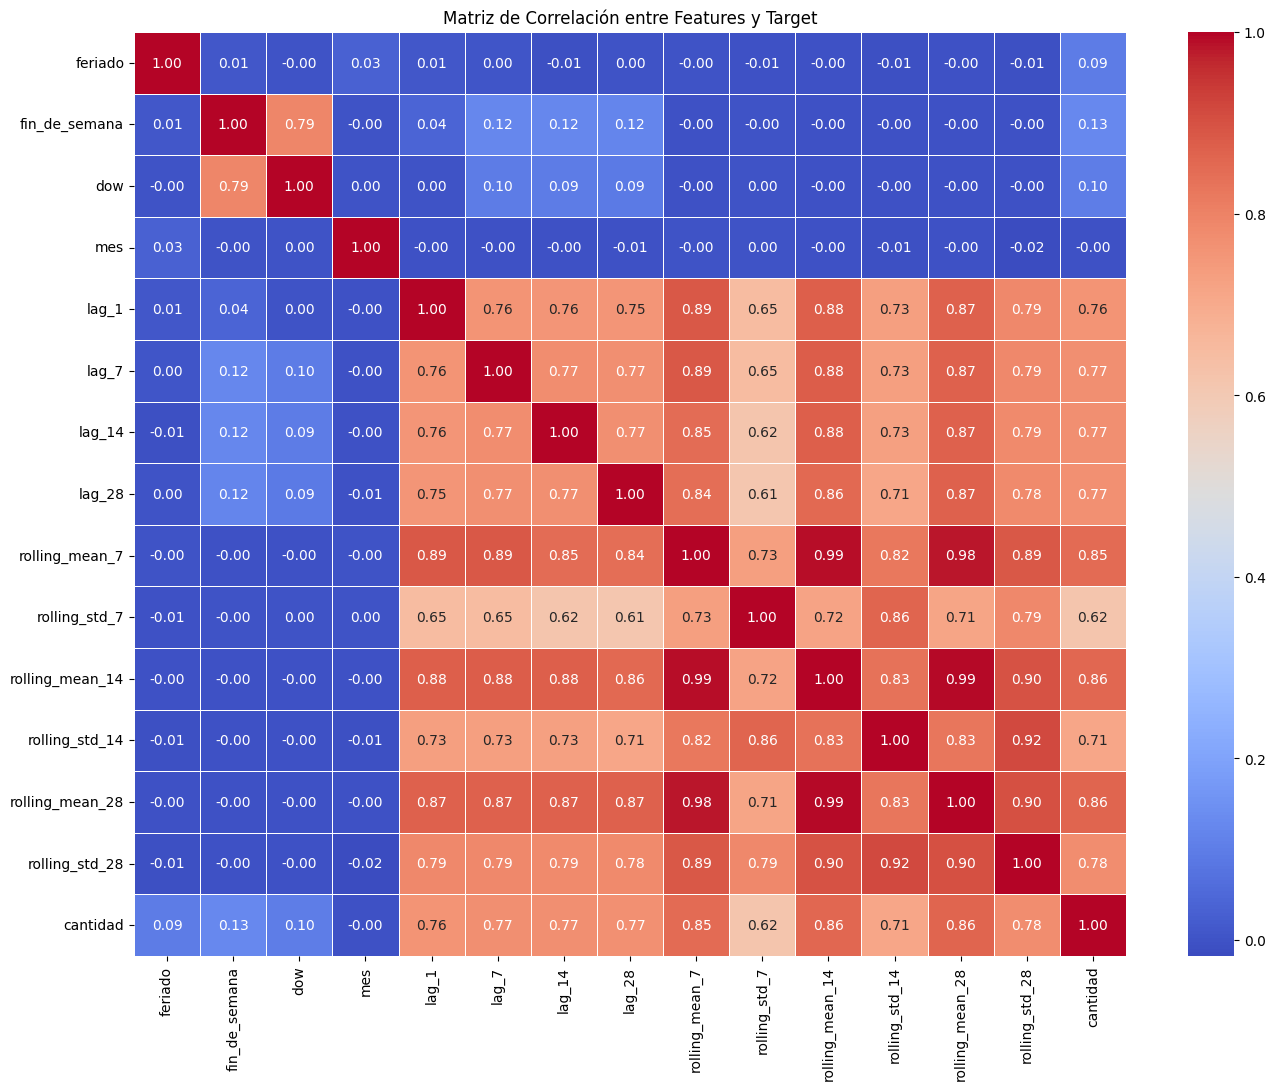

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes para la correlación
# Usamos df_model ya que es el dataframe limpio con los datos para modelar
correlation_cols = regressors + [TARGET_COL]
corr_df = df_model[correlation_cols].copy()

# Calcular la matriz de correlación
correlation_matrix = corr_df.corr()

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,      # Mostrar los valores de correlación en el mapa de calor
    cmap='coolwarm', # Elegir un mapa de color
    fmt=".2f",       # Formato de los números a dos decimales
    linewidths=.5    # Espacio entre celdas
)
plt.title('Matriz de Correlación entre Features y Target')
plt.show()

In [25]:
import joblib
from pathlib import Path

output_dir = Path("models/Random_Forest")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio de salida creado en: {output_dir}")

Directorio de salida creado en: models\Random_Forest


In [26]:
print("Exportando modelos Random Forest por segmento...")

for segment_name, model in final_models_rf.items():
    model_path = output_dir / f"plato_{segment_name}.pkl"
    joblib.dump(model, model_path)
    print(f"  Modelo para plato {segment_name} guardado en {model_path}")

print("Exportación de todos los modelos Random Forest completada.")

Exportando modelos Random Forest por segmento...
  Modelo para plato 1 guardado en models\Random_Forest\plato_1.pkl
  Modelo para plato 2 guardado en models\Random_Forest\plato_2.pkl
  Modelo para plato 3 guardado en models\Random_Forest\plato_3.pkl
  Modelo para plato 4 guardado en models\Random_Forest\plato_4.pkl
  Modelo para plato 5 guardado en models\Random_Forest\plato_5.pkl
  Modelo para plato 6 guardado en models\Random_Forest\plato_6.pkl
  Modelo para plato 7 guardado en models\Random_Forest\plato_7.pkl
  Modelo para plato 8 guardado en models\Random_Forest\plato_8.pkl
  Modelo para plato 9 guardado en models\Random_Forest\plato_9.pkl
  Modelo para plato 10 guardado en models\Random_Forest\plato_10.pkl
  Modelo para plato 11 guardado en models\Random_Forest\plato_11.pkl
  Modelo para plato 12 guardado en models\Random_Forest\plato_12.pkl
Exportación de todos los modelos Random Forest completada.


In [27]:
# 1) Features de calendario adicionales (con seguridad ante duplicados)
def add_calendar_features(df, date_col):
    d = df.copy()
    d["year"] = d[date_col].dt.year
    d["weekofyear"] = d[date_col].dt.isocalendar().week.astype(int)
    d["dayofyear"] = d[date_col].dt.dayofyear
    d["is_month_end"] = d[date_col].dt.is_month_end.astype(int)
    d["is_month_start"] = d[date_col].dt.is_month_start.astype(int)
    d["is_quarter_end"] = d[date_col].dt.is_quarter_end.astype(int)
    d["is_quarter_start"] = d[date_col].dt.is_quarter_start.astype(int)
    # codificación cíclica de día de la semana y del mes (si no existen)
    if "dia_semana" in d.columns:
        dow = d["dia_semana"].astype(int).values
    elif "dow" in d.columns:
        dow = d["dow"].astype(int).values
    else:
        dow = d[date_col].dt.dayofweek.values
        d["dow"] = dow

    d["dow_sin"] = np.sin(2*np.pi*dow/7.0)
    d["dow_cos"] = np.cos(2*np.pi*dow/7.0)

    if "mes" in d.columns:
        mm = d["mes"].astype(int).values
    elif "month" in d.columns:
        mm = d["month"].astype(int).values
    else:
        mm = d[date_col].dt.month.values
        d["mes"] = mm

    d["mes_sin"] = np.sin(2*np.pi*mm/12.0)
    d["mes_cos"] = np.cos(2*np.pi*mm/12.0)
    return d

df_cal = add_calendar_features(df_model.copy(), DATE_COL)

print("Features de calendario añadidas a df_cal. Head de df_cal:")
display(df_cal.head())

Features de calendario añadidas a df_cal. Head de df_cal:


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,dow_cos,mes_sin,mes_cos,year,weekofyear,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start
162,2021-01-29,5,12.0,300.0,2021,1,29,4,0,0,...,-0.900969,0.5,0.866025,2021,4,29,0,0,0,0
163,2021-01-29,6,8.0,192.0,2021,1,29,4,0,0,...,-0.900969,0.5,0.866025,2021,4,29,0,0,0,0
164,2021-01-29,2,18.0,576.0,2021,1,29,4,0,0,...,-0.900969,0.5,0.866025,2021,4,29,0,0,0,0
165,2021-01-29,8,6.0,168.0,2021,1,29,4,0,0,...,-0.900969,0.5,0.866025,2021,4,29,0,0,0,0
166,2021-01-29,7,5.0,110.0,2021,1,29,4,0,0,...,-0.900969,0.5,0.866025,2021,4,29,0,0,0,0


In [28]:
# Extiende lista de regresores con nuevas features
extra_feats = ["year","weekofyear","dayofyear",
               "is_month_end","is_month_start","is_quarter_end","is_quarter_start",
               "dow_sin","dow_cos","mes_sin","mes_cos"]

# Asegurarse de que las nuevas features estén en df_cal antes de añadirlas a regressors_plus
regressors_plus = list(dict.fromkeys(regressors + [c for c in extra_feats if c in df_cal.columns]))

# Actualizar df_model con las nuevas features para consistencia si se desea re-entrenar
df_model = df_cal.copy()

print(f"Total features previas: {len(regressors)} | Total features nuevas (con calendario): {len(regressors_plus)}")
regressors = regressors_plus.copy() # Actualizar la lista de regresores global
print("Lista de regresores actualizada:", regressors)

Total features previas: 14 | Total features nuevas (con calendario): 25
Lista de regresores actualizada: ['feriado', 'fin_de_semana', 'dow', 'mes', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28', 'year', 'weekofyear', 'dayofyear', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'dow_sin', 'dow_cos', 'mes_sin', 'mes_cos']


In [29]:
# Parámetros para RandomizedSearchCV de Random Forest
param_dist = {
    'n_estimators': randint(50, 200),  # Número de árboles en el bosque
    'max_depth': randint(5, 20),       # Profundidad máxima de cada árbol
    'min_samples_split': randint(2, 20), # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': randint(1, 10),  # Número mínimo de muestras requeridas para ser un nodo hoja
    'max_features': uniform(0.5, 0.5), # El número de características a considerar al buscar la mejor división
}

# Configuración de TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

best_params_per_segment = {}
segment_models = {}

print(f"Iniciando tuning para {len(df_model[PLATO_COL].unique())} segmentos...")

for i, (segment_name, segment_df) in enumerate(df_model.groupby(PLATO_COL)):
    if i % 5 == 0: # Print progress every 5 segments
        print(f"Procesando segmento {i+1}/{len(df_model[PLATO_COL].unique())}: {segment_name}")

    # Asegurarse de que el dataframe esté ordenado por fecha para TimeSeriesSplit
    segment_df = segment_df.sort_values(DATE_COL).copy()

    X = segment_df[regressors]
    y = segment_df[TARGET_COL]

    # Eliminar NaNs que puedan haber quedado de los lags/rollings al inicio de la serie de tiempo
    # RandomizedSearchCV no maneja NaNs
    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # Asegurarse de tener suficientes datos para el TimeSeriesSplit
    if len(X) < tscv.n_splits + 1: # Mínimo n_splits + 1 para TimeSeriesSplit
        print(f"  Saltando segmento {segment_name}: pocos datos ({len(X)} filas).")
        continue

    # Inicializar el modelo Random Forest
    rf = RandomForestRegressor(random_state=42, n_jobs=-1) # n_jobs=-1 para usar todos los cores

    # Configurar RandomizedSearchCV
    # No se usa early-stopping aquí, ya que RandomizedSearchCV no tiene un mecanismo directo para ello con TimeSeriesSplit
    # El early stopping se aplicará en el reentrenamiento final con un bucle manual
    random_search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=50,  # Número de combinaciones de parámetros a probar
        scoring='neg_mean_absolute_error', # Buscar minimizar MAE
        cv=tscv,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    try:
        random_search.fit(X, y)
        best_params_per_segment[segment_name] = random_search.best_params_
        print(f"  Segmento {segment_name}: Mejores parámetros encontrados: {random_search.best_params_}")
    except Exception as e:
        print(f"  Error al tunear el segmento {segment_name}: {e}")
        continue

print("Tuning completado.")

# Opcional: Mostrar algunos de los mejores parámetros encontrados
print("\nAlgunos de los mejores parámetros por segmento:")
for i, (seg, params) in enumerate(best_params_per_segment.items()):
    if i < 5: # Muestra los primeros 5
        print(f"  {seg}: {params}")
    else:
        break


Iniciando tuning para 12 segmentos...
Procesando segmento 1/12: 1
  Segmento 1: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.7469468575917173), 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 184}
  Segmento 2: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.7469468575917173), 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 184}
  Segmento 3: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.5078182033705969), 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 185}
  Segmento 4: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.5465513839029497), 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 58}
  Segmento 5: Mejores parámetros encontrados: {'max_depth': 5, 'max_features': np.float64(0.7469468575917173), 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 184}
Procesando segmento 6/12: 6
  Segmento 6

In [30]:
final_models_rf = {}
segment_predictions_rf = pd.DataFrame()

print(f"Iniciando reentrenamiento final para {len(best_params_per_segment)} segmentos...")

for i, (segment_name, params) in enumerate(best_params_per_segment.items()):
    if i % 5 == 0: # Print progress every 5 segments
        print(f"Reentrenando segmento {i+1}/{len(best_params_per_segment)}: {segment_name}")

    segment_df = df_model[df_model[PLATO_COL] == segment_name].sort_values(DATE_COL).copy()

    X = segment_df[regressors]
    y = segment_df[TARGET_COL]

    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    if len(X) == 0:
        print(f"  Saltando segmento {segment_name}: no hay datos válidos después de eliminar NaNs.")
        continue

    # Inicializar y entrenar el modelo Random Forest con los mejores parámetros
    final_rf_model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    final_rf_model.fit(X, y)

    # Guardar el modelo entrenado
    final_models_rf[segment_name] = final_rf_model

    # Generar predicciones para el conjunto de entrenamiento (opcional, para métricas)
    segment_df.loc[valid_idx, 'rf_pred'] = final_rf_model.predict(X)
    segment_predictions_rf = pd.concat([segment_predictions_rf, segment_df.loc[valid_idx]], ignore_index=True)

print("Reentrenamiento final completado.")

# Opcional: Mostrar las primeras filas de las predicciones
print("\nPrimeras filas de las predicciones de Random Forest:")
print(segment_predictions_rf[['fecha', PLATO_COL, TARGET_COL, 'rf_pred']].head())


Iniciando reentrenamiento final para 12 segmentos...
Reentrenando segmento 1/12: 1
Reentrenando segmento 6/12: 6
Reentrenando segmento 11/12: 11
Reentrenamiento final completado.

Primeras filas de las predicciones de Random Forest:
       fecha  plato  cantidad    rf_pred
0 2021-01-29      1      17.0  18.796035
1 2021-01-30      1      24.0  24.037681
2 2021-01-31      1      27.0  24.028044
3 2021-02-01      1      14.0  18.413422
4 2021-02-02      1      19.0  18.813194


In [31]:
best_params_xgb_per_segment = {}
final_models_xgb = {}

print(f"Iniciando tuning y reentrenamiento de XGBoost para {len(low_accuracy_segment_ids)} segmentos de baja precisión...")

for i, segment_name in enumerate(low_accuracy_segment_ids):
    print(f"Procesando segmento {i+1}/{len(low_accuracy_segment_ids)}: {segment_name}")

    # Filtra el DataFrame df_model para el segmento actual
    segment_df = df_model[df_model[PLATO_COL] == segment_name].sort_values(DATE_COL).copy()

    X = segment_df[regressors]
    y = segment_df[TARGET_COL]

    # Elimina NaNs
    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # Verifica si hay suficientes datos para TimeSeriesSplit
    if len(X) < tscv.n_splits + 1:
        print(f"  Saltando segmento {segment_name}: pocos datos ({len(X)} filas) para TimeSeriesSplit.")
        continue

    # Inicializa XGBRegressor
    xgb_model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

    # Configura RandomizedSearchCV
    random_search_xgb = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_dist_xgb,
        n_iter=50,
        scoring='neg_mean_absolute_error',
        cv=tscv,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    try:
        random_search_xgb.fit(X, y)
        best_params_xgb_per_segment[segment_name] = random_search_xgb.best_params_
        print(f"  Segmento {segment_name}: Mejores parámetros encontrados para XGBoost: {random_search_xgb.best_params_}")

        # Reentrena el modelo XGBoost con los mejores parámetros
        final_xgb_model = XGBRegressor(
            objective='reg:squarederror',
            n_jobs=-1,
            random_state=42,
            **random_search_xgb.best_params_
        )
        final_xgb_model.fit(X, y)
        final_models_xgb[segment_name] = final_xgb_model

    except Exception as e:
        print(f"  Error al tunear o reentrenar el segmento {segment_name} con XGBoost: {e}")
        continue

print("Tuning y reentrenamiento de XGBoost completado para los segmentos de baja precisión.")

# Opcional: Mostrar algunos de los mejores parámetros encontrados para XGBoost
print("\nAlgunos de los mejores parámetros por segmento para XGBoost:")
for i, (seg, params) in enumerate(best_params_xgb_per_segment.items()):
    if i < 5: # Muestra los primeros 5
        print(f"  {seg}: {params}")
    else:
        break

Iniciando tuning y reentrenamiento de XGBoost para 3 segmentos de baja precisión...
Procesando segmento 1/3: 12
  Segmento 12: Mejores parámetros encontrados para XGBoost: {'colsample_bytree': np.float64(0.6699819708383744), 'gamma': np.float64(0.19643366866588713), 'learning_rate': np.float64(0.16499076738130428), 'max_depth': 3, 'n_estimators': 51, 'reg_alpha': np.float64(0.09962536997579244), 'reg_lambda': np.float64(1.4654193512887936), 'subsample': np.float64(0.8233173814428391)}
Procesando segmento 2/3: 11
  Segmento 11: Mejores parámetros encontrados para XGBoost: {'colsample_bytree': np.float64(0.8916028672163949), 'gamma': np.float64(0.15425406933718916), 'learning_rate': np.float64(0.03221339552022711), 'max_depth': 9, 'n_estimators': 90, 'reg_alpha': np.float64(0.09149596755437808), 'reg_lambda': np.float64(1.3500385777897992), 'subsample': np.float64(0.7797802696552814)}
Procesando segmento 3/3: 10
  Segmento 10: Mejores parámetros encontrados para XGBoost: {'colsample_bytr

In [32]:
segment_predictions_rf['final_predictions'] = segment_predictions_rf['rf_pred']

for segment_name in low_accuracy_segment_ids:
    print(f"Actualizando predicciones para el segmento: {segment_name} con XGBoost")

    # Filtra el DataFrame segment_predictions_rf para el segmento actual
    current_segment_rf_data = segment_predictions_rf[
        segment_predictions_rf[PLATO_COL] == segment_name
    ].copy()

    # Prepara las características para la predicción de XGBoost desde este sub-DataFrame
    X_segment_for_xgb_pred = current_segment_rf_data[regressors]

    if segment_name in final_models_xgb:
        xgb_model = final_models_xgb[segment_name]
        xgb_predictions = xgb_model.predict(X_segment_for_xgb_pred)

        # Actualiza la columna 'final_predictions' en el DataFrame original
        # usando el índice del sub-DataFrame filtrado
        segment_predictions_rf.loc[current_segment_rf_data.index, 'final_predictions'] = xgb_predictions
    else:
        print(f"No se encontró modelo XGBoost entrenado para el segmento {segment_name}.")

print("Predicciones finalizadas. La columna 'final_predictions' contiene una combinación de RF y XGBoost.")
print(segment_predictions_rf[['fecha', PLATO_COL, TARGET_COL, 'rf_pred', 'final_predictions']].head())

Actualizando predicciones para el segmento: 12 con XGBoost
Actualizando predicciones para el segmento: 11 con XGBoost
Actualizando predicciones para el segmento: 10 con XGBoost
Predicciones finalizadas. La columna 'final_predictions' contiene una combinación de RF y XGBoost.
       fecha  plato  cantidad    rf_pred  final_predictions
0 2021-01-29      1      17.0  18.796035          18.796035
1 2021-01-30      1      24.0  24.037681          24.037681
2 2021-01-31      1      27.0  24.028044          24.028044
3 2021-02-01      1      14.0  18.413422          18.413422
4 2021-02-02      1      19.0  18.813194          18.813194


In [33]:
metrics_combined_df = []

print("Calculando métricas para las predicciones combinadas (RF + XGBoost)... ")

for segment_name, seg_df in segment_predictions_rf.groupby(PLATO_COL):
    y_true = seg_df[TARGET_COL]
    y_pred = seg_df['final_predictions']

    metrics = eval_metrics(y_true, y_pred)
    metrics['segmento'] = segment_name
    metrics['num_samples'] = len(seg_df)
    metrics_combined_df.append(metrics)

metrics_combined_df = pd.DataFrame(metrics_combined_df)
metrics_combined_df = metrics_combined_df.sort_values(by='MAE', ascending=True)

print("\nMétricas por segmento (Combinado RF + XGBoost):")
print(metrics_combined_df.head(12))

# Métrica global ponderada por el número de muestras
total_samples = metrics_combined_df['num_samples'].sum()
weighted_mae  = (metrics_combined_df['MAE'] * metrics_combined_df['num_samples']).sum() / total_samples
weighted_rmse = (metrics_combined_df['RMSE'] * metrics_combined_df['num_samples']).sum() / total_samples
weighted_mape = (metrics_combined_df['MAPE'] * metrics_combined_df['num_samples']).sum() / total_samples
weighted_smape= (metrics_combined_df['sMAPE'] * metrics_combined_df['num_samples']).sum() / total_samples

print("\nMétrica Global Ponderada (Combinado RF + XGBoost): ")
print(f"  MAE : {weighted_mae:.2f}")
print(f"  RMSE: {weighted_rmse:.2f}")
print(f"  MAPE: {weighted_mape:.2f}%")
print(f"  sMAPE: {weighted_smape:.2f}%")
print(f"  Accuracy(1-MAPE): {100 - weighted_mape:.2f}%")

Calculando métricas para las predicciones combinadas (RF + XGBoost)... 

Métricas por segmento (Combinado RF + XGBoost):
         MAE      RMSE        R2       MAPE      sMAPE  Accuracy(1-MAPE)  \
10  0.759079  0.974115  0.752189  28.504944  22.010419         71.495056   
9   0.815334  1.049169  0.730304  31.388924  23.687883         68.611076   
11  1.105090  1.371532  0.294532  54.038811  39.961440         45.961189   
7   1.814105  2.303712  0.432459  27.987167  23.293752         72.012833   
8   1.944270  2.428628  0.212678  39.107435  29.628225         60.892565   
6   2.309016  2.885987  0.229911  29.104315  24.416976         70.895685   
5   2.310285  2.897534  0.436292  21.669373  19.330746         78.330627   
4   2.804712  3.501839  0.258679  23.739217  21.262281         76.260783   
2   2.883456  3.628468  0.374557  23.001994  20.365853         76.998006   
3   3.214839  4.036246  0.231508  20.360498  18.585634         79.639502   
0   3.372320  4.284292  0.297069  16.663311

# Exportamos modelo

In [39]:
import joblib
from pathlib import Path

rf_output_dir = Path("../../models/Random_Forest_Final")
rf_output_dir.mkdir(parents=True, exist_ok=True)

xgb_output_dir = Path("../../models/Random_Forest_Final")
xgb_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio para modelos Random Forest creado en: {rf_output_dir}")
print(f"Directorio para modelos XGBoost optimizados creado en: {xgb_output_dir}")

Directorio para modelos Random Forest creado en: ..\..\models\Random_Forest_Final
Directorio para modelos XGBoost optimizados creado en: ..\..\models\Random_Forest_Final


In [40]:
print("Exportando modelos finales...")

# Exportar modelos Random Forest (para la mayoría de los segmentos)
for segment_name, model in final_models_rf.items():
    # Solo si este segmento NO fue optimizado con XGBoost
    if segment_name not in low_accuracy_segment_ids:
        model_path = rf_output_dir / f"plato_{segment_name}.pkl"
        joblib.dump(model, model_path)
        print(f"  Modelo Random Forest para plato {segment_name} guardado en {model_path}")

# Exportar modelos XGBoost (para los segmentos optimizados)
for segment_name, model in final_models_xgb.items():
    model_path = xgb_output_dir / f"plato_{segment_name}.pkl"
    joblib.dump(model, model_path)
    print(f"  Modelo XGBoost para plato {segment_name} guardado en {model_path}")

print("Exportación de todos los modelos finales completada.")

Exportando modelos finales...
  Modelo Random Forest para plato 1 guardado en ..\..\models\Random_Forest_Final\plato_1.pkl
  Modelo Random Forest para plato 2 guardado en ..\..\models\Random_Forest_Final\plato_2.pkl
  Modelo Random Forest para plato 3 guardado en ..\..\models\Random_Forest_Final\plato_3.pkl
  Modelo Random Forest para plato 4 guardado en ..\..\models\Random_Forest_Final\plato_4.pkl
  Modelo Random Forest para plato 5 guardado en ..\..\models\Random_Forest_Final\plato_5.pkl
  Modelo Random Forest para plato 6 guardado en ..\..\models\Random_Forest_Final\plato_6.pkl
  Modelo Random Forest para plato 7 guardado en ..\..\models\Random_Forest_Final\plato_7.pkl
  Modelo Random Forest para plato 8 guardado en ..\..\models\Random_Forest_Final\plato_8.pkl
  Modelo Random Forest para plato 9 guardado en ..\..\models\Random_Forest_Final\plato_9.pkl
  Modelo XGBoost para plato 12 guardado en ..\..\models\Random_Forest_Final\plato_12.pkl
  Modelo XGBoost para plato 11 guardado en .